In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
words = open("names.txt", "r").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [5]:
chars = sorted(set(list("".join(w for w in words))))

stoi = {s:i+1 for i, s in enumerate(chars)}
stoi["."] = 0

itos = {i:s for s, i in stoi.items()}

In [6]:
X, y = [], []

show_till = 5
i = 0
window_size = 3
for word in words:
    context = [0] * window_size
    for ch in word + ".":
        ix = stoi[ch]
        if i < show_till:
            print(f"{"".join(itos[w] for w in context)} -> {itos[ix]}")
        X.append(context)
        y.append(ix)
        context = context[1:] + [ix]
    if i < show_till: print("="*8)
    i += 1

X = torch.tensor(X)
y = torch.tensor(y)

X.shape, y.shape

... -> e
..e -> m
.em -> m
emm -> a
mma -> .
... -> o
..o -> l
.ol -> i
oli -> v
liv -> i
ivi -> a
via -> .
... -> a
..a -> v
.av -> a
ava -> .
... -> i
..i -> s
.is -> a
isa -> b
sab -> e
abe -> l
bel -> l
ell -> a
lla -> .
... -> s
..s -> o
.so -> p
sop -> h
oph -> i
phi -> a
hia -> .


(torch.Size([228146, 3]), torch.Size([228146]))

In [60]:
C = torch.randn((27, 2))  # Embedding matrix

In [61]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.9715, -1.6202])

In [62]:
X_emb = C[X]
X_emb.shape

torch.Size([228146, 3, 2])

In [63]:
g = torch.Generator().manual_seed(42)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
C = torch.randn((27, 2), generator=g)

In [64]:
parameters = [W1, b1, W2, b2, C]  # Embedding is also learned parameter
# We can think of it as of a weight matrix for one-hot encoded indeces

lr = 0.1

for p in parameters:
    p.requires_grad = True

for epoch in range(100):
    # Forward pass:
    X_emb = C[X]
    h = F.tanh(X_emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    out = F.softmax(logits, dim=1)
    # loss = -out[torch.arange(32), y].log().mean().item()
    loss = F.cross_entropy(logits, y)
    if epoch % 10 == 0: print(loss.item())
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -lr * p.grad

13.941655158996582
7.7270073890686035
6.089615821838379
5.176519870758057
4.549757480621338
4.072685718536377
3.7436749935150146
3.600302219390869
3.4234490394592285
3.2891695499420166


Above is the training on entire dataset (traditional GD), but it's slow & we'd rather use minibatch splits

In [67]:
g = torch.Generator().manual_seed(42)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
C = torch.randn((27, 2), generator=g)

In [68]:
parameters = [W1, b1, W2, b2, C]  # Embedding is also learned parameter
# We can think of it as of a weight matrix for one-hot encoded indeces

lr = 0.1

for p in parameters:
    p.requires_grad = True

for epoch in range(1000):
    # Forward pass:
    batch_indices = torch.randint(0, X.shape[0], (32,))  # Batches of 32
    X_emb = C[X[batch_indices]]
    h = F.tanh(X_emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    out = F.softmax(logits, dim=1)
    # loss = -out[torch.arange(32), y].log().mean().item()
    loss = F.cross_entropy(logits, y[batch_indices])
    if epoch % 100 == 0: print(loss.item())
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -lr * p.grad

14.27030086517334
3.2506325244903564
2.698181629180908
2.699838161468506
2.6895885467529297
3.034855365753174
3.049379348754883
2.605607271194458
2.3097779750823975
2.469055414199829


In [73]:
# Don't get fooled! Loss printed is only for minibatches
# Let's see overall loss

X_emb = C[X]
X_emb = X_emb.view(-1, 6)
h = F.tanh(X_emb @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y)
print(loss.item())  # Okay, aint bad

2.731269121170044


### LR pick

In [76]:
lre = torch.linspace(-3, 0, 1_000)
lrs = 10 ** lre  # Exponentially spaced learning rates

In [77]:
g = torch.Generator().manual_seed(42)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
C = torch.randn((27, 2), generator=g)

In [78]:
for i in range(1_000):
    parameters = [W1, b1, W2, b2, C]  # Embedding is also learned parameter
# We can think of it as of a weight matrix for one-hot encoded indeces

for p in parameters:
    p.requires_grad = True

lrei = []
lossi = []

for i in range(1000):
    # Forward pass:
    batch_indices = torch.randint(0, X.shape[0], (32,))  # Batches of 32
    X_emb = C[X[batch_indices]]
    h = F.tanh(X_emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    out = F.softmax(logits, dim=1)
    # loss = -out[torch.arange(32), y].log().mean().item()
    loss = F.cross_entropy(logits, y[batch_indices])
    if epoch % 100 == 0: print(loss.item())
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    lrei.append(lre[i])
    lossi.append(loss.item())

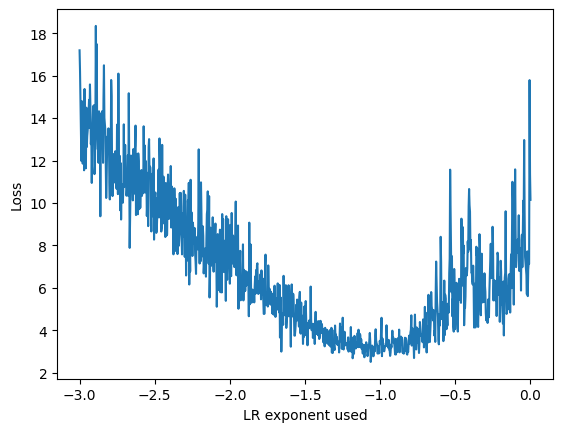

In [80]:
plt.xlabel("LR exponent used")
plt.ylabel("Loss")
plt.plot(lrei, lossi);

We can see that updates lose their meaning with big exponents and small exponents make small progress.
Reasonable choice is somewhere in this valley around -1.0.
That's to say lr=0.1 was a reasonable choice. But with such an initialization it's pretty unfair for small learning rates, since loss is high there due to random intialization

In [86]:
g = torch.Generator().manual_seed(42)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
C = torch.randn((27, 2), generator=g)

In [90]:
parameters = [W1, b1, W2, b2, C]

lr = 0.01  # Did LR decay here. Ran 10_000 with 0.1 and now another 10_000 with 0.01

for p in parameters:
    p.requires_grad = True

for epoch in range(10_000):
    # Forward pass:
    batch_indices = torch.randint(0, X.shape[0], (32,))  # Batches of 32
    X_emb = C[X[batch_indices]]
    h = F.tanh(X_emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    out = F.softmax(logits, dim=1)
    # loss = -out[torch.arange(32), y].log().mean().item()
    loss = F.cross_entropy(logits, y[batch_indices])
    if epoch % 1_000 == 0: print(loss.item())
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -lr * p.grad

2.338639974594116
2.54370379447937
2.0604248046875
2.378545045852661
2.4953322410583496
2.1550145149230957
2.4206411838531494
2.219498634338379
2.4089295864105225
2.087190866470337


In [92]:
X_emb = C[X]
X_emb = X_emb.view(-1, 6)
h = F.tanh(X_emb @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y)
print(loss.item())  # Surpassed bigram

2.399085760116577


### Train/Dev/Test!

In [7]:
train_ratio = 0.8
dev_ratio = 0.1

m = X.shape[0]
indices = torch.arange(0, m)

import random
random.seed(42)
random.shuffle(indices)
train_indices = indices[:int(m * train_ratio)]
dev_indices = indices[int(m * train_ratio):int(m*(train_ratio+dev_ratio))]
test_indices = indices[int(m*(train_ratio+dev_ratio)):]

X_train = X[train_indices]
y_train = y[train_indices]

X_dev = X[dev_indices]
y_dev = y[dev_indices]

X_test = X[test_indices]
y_test = y[test_indices]

In [8]:
(X_train.shape, y_train.shape), (X_dev.shape, y_dev.shape), (X_test.shape, y_test.shape)

((torch.Size([182516, 3]), torch.Size([182516])),
 (torch.Size([22815, 3]), torch.Size([22815])),
 (torch.Size([22815, 3]), torch.Size([22815])))

In [150]:
g = torch.Generator().manual_seed(2147483647)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
C = torch.randn((27, 2), generator=g)

In [151]:
parameters = [W1, b1, W2, b2, C]
for p in parameters:
    p.requires_grad = True

lr = 0.01


for epoch in range(10_000):
    # Forward pass:
    trainbatch_indices = torch.randint(0, X_train.shape[0], (32,))  # Batches of 32
    X_train_emb = C[X_train[trainbatch_indices]]
    h = F.tanh(X_train_emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    out = F.softmax(logits, dim=1)
    loss = F.cross_entropy(logits, y_train[trainbatch_indices])
    if epoch % 1_000 == 0:
        print(f"Train Loss: {loss.item()}")
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -lr * p.grad

Train Loss: 15.693534851074219
Train Loss: 2.4692018032073975
Train Loss: 2.8159830570220947
Train Loss: 3.0330896377563477
Train Loss: 2.4251551628112793
Train Loss: 2.7936272621154785
Train Loss: 2.713792324066162
Train Loss: 2.3674235343933105
Train Loss: 2.717252254486084
Train Loss: 2.38356876373291


In [152]:
Xtest_emb = C[X_test]
Xtest_emb = Xtest_emb.view(-1, 6)
h = F.tanh(Xtest_emb @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_test)
print(f"Test: {loss.item()}")

Xtrain_emb = C[X_train]
Xtrain_emb = Xtrain_emb.view(-1, 6)
h = F.tanh(Xtrain_emb @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_train)
print(f"Train: {loss.item()}")

Test: 2.5832533836364746
Train: 2.4703738689422607


In [ ]:
# More of underfitting than of overfitting
# INCREASE NET CAPACITY!!!

In [174]:
g = torch.Generator().manual_seed(2147483647)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
C = torch.randn((27, 2), generator=g)

parameters = [W1, b1, W2, b2, C]
for p in parameters:
    p.requires_grad = True

lr = 0.05


for epoch in range(100_000):
    # Forward pass:
    trainbatch_indices = torch.randint(0, X_train.shape[0], (32,))  # Batches of 32
    X_train_emb = C[X_train[trainbatch_indices]]
    h = F.tanh(X_train_emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[trainbatch_indices])
    if epoch % 10_000 == 0:
        print(f"Train Loss: {loss.item()}")
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -lr * p.grad

Train Loss: 27.411684036254883
Train Loss: 2.0866973400115967
Train Loss: 2.617626190185547
Train Loss: 2.4805662631988525
Train Loss: 2.368175506591797
Train Loss: 2.741666793823242
Train Loss: 2.0307633876800537
Train Loss: 2.801377058029175
Train Loss: 2.4272634983062744
Train Loss: 1.998099684715271


In [175]:
Xtest_emb = C[X_test]
Xtest_emb = Xtest_emb.view(-1, 6)
h = F.tanh(Xtest_emb @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_test)
print(f"Test: {loss.item()}")

Xtrain_emb = C[X_train]
Xtrain_emb = Xtrain_emb.view(-1, 6)
h = F.tanh(Xtrain_emb @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_train)
print(f"Train: {loss.item()}")

Test: 2.43359375
Train: 2.1632885932922363


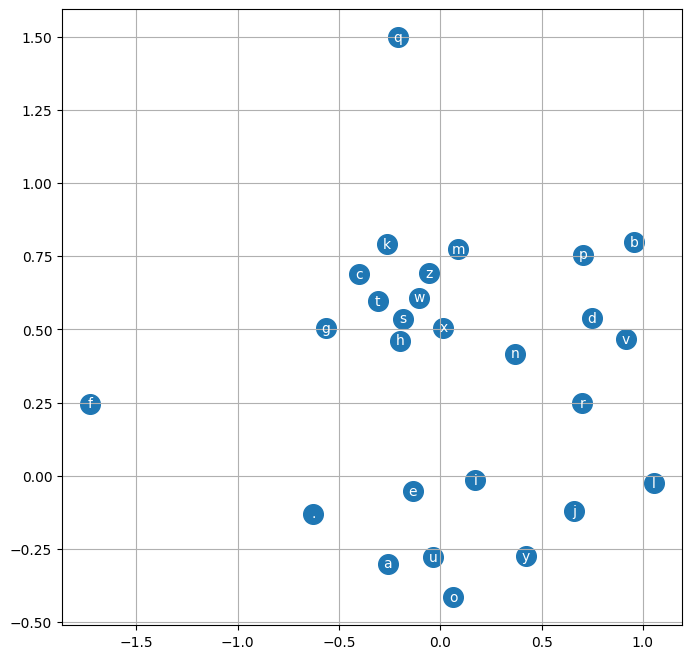

In [176]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200);

for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

In [247]:
stepi = []
lossi = []

In [248]:
g = torch.Generator().manual_seed(2147483647)
W1 = torch.randn((30, 180), generator=g)
b1 = torch.randn(180, generator=g)
W2 = torch.randn((180, 27), generator=g)
b2 = torch.randn(27, generator=g)
C = torch.randn((27, 10), generator=g)

parameters = [W1, b1, W2, b2, C]
for p in parameters:
    p.requires_grad = True

for epoch in range(200_000):
    # Forward pass:
    trainbatch_indices = torch.randint(0, X_train.shape[0], (64,))  # Batches of 32
    X_train_emb = C[X_train[trainbatch_indices]]
    h = F.relu(X_train_emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[trainbatch_indices]) + (W1**2).mean() + (W2**2).mean()
    if epoch % 10_000 == 0:
        print(f"Train Loss: {loss.item()}")
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.08 if epoch < 100_000 else 0.004
    for p in parameters:
        p.data += -lr * p.grad
    stepi.append(epoch)
    lossi.append(loss.log10().item())  # log to squash los vertically

Train Loss: 77.51216888427734
Train Loss: 3.0127322673797607
Train Loss: 2.4242334365844727
Train Loss: 2.3086605072021484
Train Loss: 1.9303091764450073
Train Loss: 2.2767081260681152
Train Loss: 1.9242544174194336
Train Loss: 2.010711908340454
Train Loss: 1.9462618827819824
Train Loss: 2.2484219074249268
Train Loss: 1.8316384553909302
Train Loss: 2.0145375728607178
Train Loss: 1.760641098022461
Train Loss: 2.043942928314209
Train Loss: 1.6870050430297852
Train Loss: 2.0504915714263916
Train Loss: 1.9350264072418213
Train Loss: 2.0180671215057373
Train Loss: 1.8272696733474731
Train Loss: 2.1576662063598633


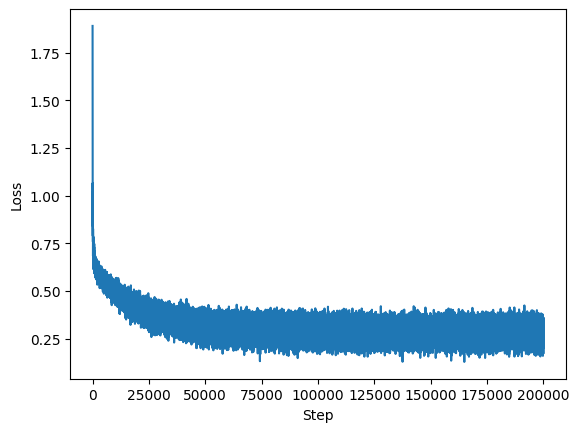

In [249]:
plt.xlabel("Step")
plt.ylabel("Loss")
plt.plot(stepi, lossi);

In [250]:
Xtest_emb = C[X_test]
Xtest_emb = Xtest_emb.view(-1, 30)
h = F.relu(Xtest_emb @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_test)
print(f"Test: {loss.item()}")

Xtrain_emb = C[X_train]
Xtrain_emb = Xtrain_emb.view(-1, 30)
h = F.relu(Xtrain_emb @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_train)
print(f"Train: {loss.item()}")

Test: 2.160083055496216
Train: 1.874122142791748


In [268]:
for i in range(30):
    res = ""
    context = [0] * 3
    while True:
        emb = C[torch.tensor(context)]
        h = torch.relu(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        res += itos[ix]
        if ix == 0:
            break
    print(res)

gionni.
aliya.
mara.
lee.
gurdy.
bailynn.
riyah.
ray.
kathlynileigh.
dashie.
ran.
karmi.
jupheo.
sia.
avyn.
zemmylanna.
ava.
ree.
andrix.
charte.
den.
relia.
karho.
koryn.
zena.
daina.
brinebelaelah.
rcessinooriella.
keilah.
brysen.


### Okay, technically I improved the network already (kind of) and beat 2.2 test loss (tho my model is overfitting), so E01 is already accomplished

In [17]:
# E02 Parameter initialization tuning
# 2.1 - Initialize parameters, so that all probabilities are equally distributed
# INTERESTING!!!

"""
To get equal probabilities for each class we need our logits to be equal.
Logits are calculated through linear transformations of input.
Input plays important role (etc. 2*3 != 4*3)
So do parameters. That's why setting parameters to 0 is an option.
(2*0 == 4*0). It will produce equally likely next characters vector.

Tho bias doesn't really matter here. If X @ W results in matrix filled with zeros.
It doesn't matter what we add, all elements there will be equal.
"""
W1 = torch.zeros((30, 180))
b1 = torch.zeros(180)
W2 = torch.zeros((180, 27))
b2 = torch.zeros(27)
C = torch.randn((27, 10))

# Forward pass:
X_train_emb = C[X_train]
h = F.tanh(X_train_emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_train)
print(loss.item())

probabilities = F.softmax(logits, dim=1)
probabilities[0]

3.29583740234375


tensor([0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370])

In [14]:
g = torch.Generator().manual_seed(2147483647)

In [16]:
for i in range(5):
    res = ""
    context = [0] * 3
    while True:
        emb = C[torch.tensor(context)]
        h = torch.relu(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        res += itos[ix]
        if ix == 0:
            break
    print(res)

# This zero initialized untrained model generates absolute dawgshit!
# Cool

ffipafrcikrlegnskraifqzlbjhkrrhmmbgzdavdgxecxgjsfptalmzgpejmfxbglswoztduepxtjsixunqxek.
mgwxeybgogtecytlntkvcqmveyqeveqrvugnxvksrqbnxidpozmsynyfwegzap.
y.
.
lhydetajbnoaidtqhcopkkbipilcae.


# The other way of completing this exercise is purely **mathematical**
We use CrossEntropy Loss. Roughly speaking it's a:
$$-\log(p_{correct})$$ For one sample.
Now uniform distribution implies p_correct = any other p.
In other words it's 1/C where C - number of classes.<br>
In our case C=27. It's 1/27th.
Therefore loss is $-\log(1/27) = log(27) = 3.2958$
It's our loss!

In [19]:
torch.log(torch.tensor(27))

tensor(3.2958)

Honestly I'm having hard time understanding what 2.2 asks to do.
Is it about some smart initialization techniques (Like He or Xavier)
Or is it about trying to achieve uniform model performance in different manner
I'll try to find more info on discord

Speaking of E03 I'll do it tomorrow
It's just too much for me to read and implement 19 pages in one evening after all this work done.
Notebook will be finished tomorrow (who df will read it? This message will survive a couple of hours and then will be deleted.
No one will read this shit lol)